## Problem 1 (35 points): Nonlinear Constrained Optimization, Duality, Convexity

#### A. (10 points): 
Formulate and solve the following problem in Pyomo. Use the most appropriate solver that you have access to.

$ min -x_1-x_2  $ </br>
subject to: </br>
$x_1x_2 <= 4 $



In [ ]:
from pyomo.environ import *

# Define the model
m = ConcreteModel()

# Define the decision variables
m.x1 = Var(within=NonNegativeReals)
m.x2 = Var(within=NonNegativeReals)

# Define the objective function
m.obj = Objective(expr = -1*m.x1 + (-1*m.x2), sense = minimize )

# Define the constraints
m.con1 = Constraint(expr = m.x1*m.x2 <= 4)

# Create the solver
solver = SolverFactory("ipopt")

# Solve the model
results = solver.solve(m)

# Print the results
print('optimal x1 =', value(m.x1))
print('optimal x2 =', value(m.x2))
print('optimal obj =', value(m.obj))

optimal x1 = 2.000000011218813
optimal x2 = 2.0000000062752834
optimal obj = -4.000000017494097


### B. (15 points)  
Formulate and solve the Dual Formulation of above problem. To get full points, follow the steps outlined in the lecture and explain in text/Markdown cell what you did to formulate the Dual problem. 

#### Text answer of B. here:

Step 1: formulate Langrangean:

$ L(x_1,x_2,μ) = -x_1 - x_2 + μ(x_1x_2-4) $

Step 2: Derivative of L with respect to x1 and x2 = 0:

$ dL/dx_1 = -1 + μx_2 = 0  => x_2 = 1/μ $

$ dL/dx_2 = -1 + μx_1 = 0  => x_1 = 1/μ $

Step 3: Write L in terms of μ and maximize L:

$ L(μ) = -(1/μ) - (1/μ) + μ((1/μ^2) - 4) $

max L(μ)

s.t μ >= 0


In [ ]:
#Dual formulation here Pyomo solution here:
d = ConcreteModel()
d.mu = Var(within=NonNegativeReals)

def obj(d):
    x1 = 1/d.mu
    x2 = 1/d.mu
    return (-1*x1) + (-1*x2) + d.mu*(x1*x2-4)

d.obj = Objective(rule = obj, sense = maximize)

# Create the solver
solver = SolverFactory("ipopt")

# Solve the model
results = solver.solve(d)

# Print the results
print('optimal mu =', value(d.mu))
print('optimal obj =', value(d.obj))

print('duality gap = ', abs(value(d.obj)-value(m.obj)))

optimal mu = 0.5000000003131835
optimal obj = -4.0
duality gap =  1.7494096837822326e-08


### C. (10 points) 

Compare solutions obtained in part A and part B. 
What is the duality gap? 
If not zero, explain why by discussing and proving convexity of original problem (Primal).

#### Answer Part C here: 

Duality gap is essentially zero. This is guaranteed to occur if Primal is convex, gap could be positive if Primal is not convex. So this does not immediately tell us Primal is convex, but it could be. We could check Primal for convexity, but that is not asked here.

## Problem 2 (10 points) - Linear Programming Solutions

A LP formulation has been coded in Pyomo below. Solve this problem graphically, by

In [ ]:
# create a model
from pyomo.environ import *
lp = ConcreteModel()

# create variables
lp.x = Var(within=NonNegativeReals)
lp.y = Var(within=NonNegativeReals)

# set objective function
lp.obj = Objective(expr = 3*lp.x + 2*lp.y, sense=minimize)

# set constraints
lp.con1 = Constraint(expr = 400*lp.x + 270*lp.y >= 4500)
lp.con2 = Constraint(expr = lp.x >= 1)
lp.con3 = Constraint(expr = lp.y >= 1)

# solve the problem
solver = SolverFactory('glpk')
solver.solve(lp)

# print the results
# Print the results
print('optimal x =', value(lp.x))
print('optimal x =', value(lp.y))
print('optimal obj =', value(lp.obj))

optimal x = 1.0
optimal x = 15.1851851851852
optimal obj = 33.370370370370395


Matplotlib is building the font cache; this may take a moment.


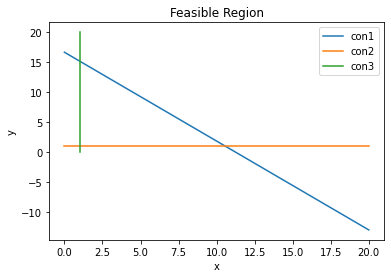

In [ ]:
#Plotting Feasible Region:

import numpy as np
import matplotlib.pyplot as plt

# Define the constraints
x = np.linspace(0, 20, 1000)
y1 = (4500 - 400*x) / 270
y2 = np.ones_like(x)

# Plot the constraints
plt.plot(x, y1, label=r'con1')
plt.plot(x, y2, label=r'con2')
plt.plot(y2, x, label=r'con3')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Feasible Region')
plt.legend()

# Show the plot
plt.show()

## Answer Problem 2 here:

Describe feasible region in figure above:

The feasible region is unbounded, and is defined by constraint 1 (right-upper side), con2 (above) and con3 (right side of it). Since this is a minimization problem, that is not a problem. If it was a maximization problem, solution would be inf. There only 2 vertices, defined by intersection of con1+con3 and con1+con2: (1,15.185),(10.575,1) 

Optimal Solution: 33.373
x = 1
y = 15.185

## Problem 3 - Mixed - Integer Formulation & Branch-and-Bound:
### A. (25 points) 

A small planning problem must be solved with the objective to maximize profit, as described below. The problem has been mostly formulated in Pyomo already, your goal is to explain the formulation and make minor edits to it if needed.

Product Z must be produced using raw materials X and Y. 
First X must be processed to produce Y and then Y is processed to produce Z. The technology for each of these processing steps is available, but comes at different fixed costs if it is decided to build them (land, capital cost) and variable costs as they are operated that depend on the amount processed (operating costs for production). 
Y can also be purchased directly from market. 

The following are options: Building plant A (converts X to Y), 
or Building plant B (converts X to Y), or Purchasing Y from the market, 
Then Plant C must be built that takes in Y and produces Z. 

Only Plant A or B can be built due to limited resources.

Based on costs and correlations that describe the efficiency of each plant to convert a raw material to its product, the following optimization problem has been formulated in Pyomo to solve this planning problem.

Decide a solver and solve this problem. In the Markdown text that follows, describe each variable and each constraint, fixed costs, variable costs and any bounds that exist. In other words, understand the formulation and explain it.

In [ ]:
from pyomo.environ import *

# Create a model object
model = ConcreteModel()

# Define variables
model.feedx = Var(within=NonNegativeReals)
model.xtoa = Var(within=NonNegativeReals)
model.xtob = Var(within=NonNegativeReals)
model.ytoz = Var(within=NonNegativeReals)
model.ypurch = Var(within=NonNegativeReals)
model.yfroma = Var(within=NonNegativeReals, bounds=(None, 5))
model.yfromb = Var(within=NonNegativeReals)
model.zprod = Var(within=NonNegativeReals, bounds=(None, 1))

model.b1 = Var(within=Binary)
model.b2 = Var(within=Binary)
model.b3 = Var(within=Binary)

# Define objective function - must maximize:
model.objvar = Objective(expr = -1.8*model.feedx - 7*model.ypurch + 13*model.zprod
                                - model.yfroma - 1.2*model.yfromb - 2*model.ytoz
                                - 3.5*model.b1 - model.b2 - 1.5*model.b3, sense = maximize)

# Define constraints

model.e1 = Constraint(expr = -0.85*model.xtoa + model.yfroma == 0)

model.e2 = Constraint(expr = -0.95*model.xtob + model.yfromb == 0)

model.e3 = Constraint(expr = -0.9*model.ytoz + model.zprod == 0)

model.e4 = Constraint(expr = -model.ytoz + model.ypurch + model.yfroma + model.yfromb  == 0)

model.e5 = Constraint(expr = model.feedx - model.xtoa - model.xtob == 0)

model.e6 = Constraint(expr = model.ytoz - 100*model.b1 <= 0)

model.e7 = Constraint(expr = model.xtoa - 100*model.b2 <= 0)

model.e8 = Constraint(expr = model.xtob - 100*model.b3 <= 0)

#this constraint is added based on description:
model.e9 = Constraint(expr = model.b2 + model.b3 <= 1)

# Solve the model
SolverFactory('glpk').solve(model)

# Print the solution
print(f"feedx = {value(model.feedx)}")
print(f"xtoa = {value(model.xtoa)}")
print(f"xtob = {value(model.xtob)}")
print(f"ytoz = {value(model.ytoz)}")
print(f"ypurch = {value(model.ypurch)}")
print(f"yfroma = {value(model.yfroma)}")
print(f"yfromb = {value(model.yfromb)}")
print(f"zprod = {value(model.zprod)}")
print(f"b1 = {value(model.b1)}")
print(f"b2 = {value(model.b2)}")
print(f"b3 = {value(model.b3)}")
print(f"objvar = {value(model.objvar)}")

feedx = 1.30718954248366
xtoa = 1.30718954248366
xtob = 0.0
ytoz = 1.11111111111111
ypurch = 0.0
yfroma = 1.11111111111111
yfromb = 0.0
zprod = 1.0
b1 = 1.0
b2 = 1.0
b3 = 0.0
objvar = 2.8137254901960826


## Answer Part A:

### Variables:

feedx = total x purchased/ fed into process

xtoa = amount of x sent to a

xtob = amount of x sent to b

ytoz = amount of y input into C to be turned into z

ypurch = amount of y purchased

yfroma = amount of y made from A

yfromb = amount of y made from B

zprod = amount of z produced

b1 = fixed cost of making factory C

b2 = fixed cost of making plant A

b3 = fixed cost of making plant B


### Cost parameters: 

feed stock cost of x = 1.8

y purchasing cost = 7

z selling price = 13

y manufacturing cost A = 1

y manufacturing cost B = 1.2

y consumption cost C = 2

A fixed cost = 1

B fixed cost = 1.5

C fixed cost = 3.5


### Constraint explanations:

e1: amount of y produced in factory A based on X conversion

e2: amount of y produced in factory B based on X conversion

e3: amount of z produced in factory A based on X conversion

e4: total amount of y neither purchhased or produced sent to C

e5: amount of X feedstock to purchase

e6: limit on y consumed by Plant C

e7: limit on x consumed by Plant A

e8: limit on x consumed by Plant B

**e9: Choosing between making only one of Plant A or B**


### Bounds explanations:

The amount of y that can be produced from A is bounded to (0,5)

The amount of Z that can be produced from C is bounded to (0,1)


### What type of formulation is this?

This is a MILP - mixed integer linear problem



### B. (10 points) If this problem is solved with a branch-and-bound algorithm, solve below the "Root Node" formulation only. 

Is the solution that you get an Upper Bound or a Lower Bound?
If you had to make a decision on what variable to branch next, what would you choose and why? No need to solve anything beyond the root node, but just explain in Markdown/text.



In [ ]:
# Copy-paste formulation below, but edit it accordingly to represent the Root node of B&B tree:
from pyomo.environ import *

# Create a model object
model = ConcreteModel()

# Define variables - ALL will be real variables (binaries are relaxed, this now becomes a Linear Programming formulation - LP)
model.feedx = Var(within=NonNegativeReals)
model.xtoa = Var(within=NonNegativeReals)
model.xtob = Var(within=NonNegativeReals)
model.ytoz = Var(within=NonNegativeReals)
model.ypurch = Var(within=NonNegativeReals)
model.yfroma = Var(within=NonNegativeReals, bounds=(None, 5))
model.yfromb = Var(within=NonNegativeReals)
model.zprod = Var(within=NonNegativeReals, bounds=(None, 1))

model.b1 = Var(within=NonNegativeReals)
model.b2 = Var(within=NonNegativeReals)
model.b3 = Var(within=NonNegativeReals)

# Define objective function
model.objvar = Objective(expr = -1.8*model.feedx - 7*model.ypurch + 13*model.zprod
                                - model.yfroma - 1.2*model.yfromb - 2*model.ytoz
                                - 3.5*model.b1 - model.b2 - 1.5*model.b3, sense = maximize)

# Define constraints

model.e1 = Constraint(expr = -0.85*model.xtoa + model.yfroma == 0)

model.e2 = Constraint(expr = -0.95*model.xtob + model.yfromb == 0)

model.e3 = Constraint(expr = -0.9*model.ytoz + model.zprod == 0)

model.e4 = Constraint(expr = -model.ytoz + model.ypurch + model.yfroma + model.yfromb  == 0)

model.e5 = Constraint(expr = model.feedx - model.xtoa - model.xtob == 0)

model.e6 = Constraint(expr = model.ytoz - 100*model.b1 <= 0)

model.e7 = Constraint(expr = model.xtoa - 100*model.b2 <= 0)

model.e8 = Constraint(expr = model.xtob - 100*model.b3 <= 0)

model.e9 = Constraint(expr = model.b2 + model.b3 <= 1)

# Solve the model
SolverFactory('glpk').solve(model)

# Print the solution
print(f"feedx = {value(model.feedx)}")
print(f"xtoa = {value(model.xtoa)}")
print(f"xtob = {value(model.xtob)}")
print(f"ytoz = {value(model.ytoz)}")
print(f"ypurch = {value(model.ypurch)}")
print(f"yfroma = {value(model.yfroma)}")
print(f"yfromb = {value(model.yfromb)}")
print(f"zprod = {value(model.zprod)}")
print(f"b1 = {value(model.b1)}")
print(f"b2 = {value(model.b2)}")
print(f"b3 = {value(model.b3)}")
print(f"objvar = {value(model.objvar)}")


feedx = 1.16959064327485
xtoa = 0.0
xtob = 1.16959064327485
ytoz = 1.11111111111111
ypurch = 0.0
yfroma = 0.0
yfromb = 1.11111111111111
zprod = 1.0
b1 = 0.0111111111111111
b2 = 0.0
b3 = 0.0116959064327485
objvar = 7.282748538011708


## Answer Part B here:

We relaxed all binaries, solved LP and got a non-binary solution. Since this is a maximization problem, the solution is an Upper Bound (meaning our optimal objective cannot be larger than 7.283).

Since we did not get the optimal solution, we can continue "branching" on binary decisions. A heuristic is to branch (fix to 0 or 1) the noninteger variables. So either b1 or b3 could be selected here. Since b1 participates in the objective with a higher coefficient, maybe we could pick b1. Any decision here would be correct, as long as it is justified.

### Problem 4 (30 points) - Data-Driven Optimization using Direct-Search:

You are using a Python implementation of a Direct-Search algorithm provided to you by your colleague to minimize a 1-d function provided below. 

Run the code and assess whether it is working. Your colleague was not good about adding comments, so you'll have to understand the code. Add comments as you wish to explain what is happening.

Knowing about the components and behavior of a good direct-search algorithm, try to debug the code below. 

Can you fix this code and run it efficiently, so that it converges without hitting the upper limit of samples (100)? 

Below your solution, explain in text/Markdown, what you changed/fixed and why.

The function is also plotted for you below to help you.

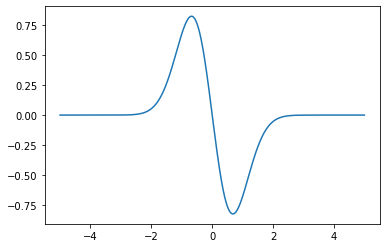

step from 2.5 where f= -0.005981458366571822 to 2.75 where f= -0.0016271317645622963 with step size= 0.25
step from 2.75 where f= -0.0016271317645622963 to 2.875 where f= -0.00080723378991049 with step size= 0.125
step from 2.875 where f= -0.00080723378991049 to 2.9375 where f= -0.0005616528903507365 with step size= 0.0625
step from 2.9375 where f= -0.0005616528903507365 to 2.96875 where f= -0.0004670752199203272 with step size= 0.03125
step from 2.96875 where f= -0.0004670752199203272 to 2.984375 where f= -0.0004256172113372471 with step size= 0.015625
step from 2.984375 where f= -0.0004256172113372471 to 2.9921875 where f= -0.00040621300415084964 with step size= 0.0078125
step from 2.9921875 where f= -0.00040621300415084964 to 2.99609375 where f= -0.00039682661005943583 with step size= 0.00390625
step from 2.99609375 where f= -0.00039682661005943583 to 2.998046875 where f= -0.00039221047093767144 with step size= 0.001953125
step from 2.998046875 where f= -0.00039221047093767144 to 2.

In [ ]:
## Python implementation direct search:
from pylab import *

def p1(x):
    return -(x + sin(x)) * exp(-x**2.0)


# Create a plot of the function
x = np.linspace(-5, 5, 1000)
plt.plot(x, p1(x))
# Show the plot
plt.show()


delta = 0.5
epsilon = 0.0001

# Starting 2 samples
x0 = -2
f0 = p1(x0)


xp = x0
fp = f0

xc = x0 + delta
fc = p1(xc)

nsamp = 2

#iteration till reaching minimum 

while ((abs(delta) > epsilon) and (nsamp < 100)) : 
    # stepsize convergence
    if (fp>fc):
        delta = delta
    else:
        delta = 0.5*delta
    xp = xc
    fp = fc
    
    #next sample

    xc = xc + delta
    fc = p1(xc)

    print('step from',xp,'where f=',fp,'to',xc,'where f=',fc,'with step size=',delta)
    nsamp = nsamp + 1

#Final solution:
print('final x', xc)
print('final obj',fc)

print('total samp',nsamp)

## Text Answer of Problem 4:

This is a direct-search problem. Looking at the function, it is nonconvex, so algorithm convergence will depend on starting point. Function also has "plateus" so if the algorithm does not have all features for convergence (descent mechanism, mechanism to reduce step size to zero, good sampling design/well-poised), it will not converge. 

The main reason it does not is because it is missing the mechanism to reduce step size to zero. So the delta step must be reduced when a successful step occurs. Any coefficient less than 1 to multiply the delta step within the "else" statement will do. 

Some of you also changed the starting point, to start close to true solution. That is a good idea, but it does not fully solve convergence issue. In reality, we don't know true solution. 

Some of you changed the tolerance to be larger or smaller. That can also affect iterations, but does not solve the problem of convergence. 

Some of you changed delta itself. That again will affect iterations, but will not alone fix the convergence issue. 

Partial credit was given to any of above changes, but if step size decrease was not added, full credit was not given.

# The End.. THANK YOU and GOOD LUCK!